In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import (
    EulerSolver,
    plot_1d_slice,
)
from superfv.initial_conditions import decaying_turbulence_1d

In [2]:
seed = 5
N = 100
T = 0.02

configs = {
    "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc", p=1, MUSCL=True, MUSCL_limiter="moncen", flux_recipe=2
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        ZS=True,
        adaptive_dt=True,
        PAD={"rho": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        MOOD=True,
        limiting_vars=("rho", "vx"),
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        PAD={"rho": (0, None)},
    ),
}

In [3]:
for seed in range(1, 11):
    sims = {}
    for name, config in configs.items():
        print(f"Running simulation: {name}")
        sim = EulerSolver(
            ic=partial(decaying_turbulence_1d, seed=seed, M=10, h=1 / N),
            isothermal=True,
            nx=N,
            **config,
        )

        try:
            if config.get("MUSCL", False):
                sim.musclhancock(T, allow_overshoot=True)
            else:
                sim.run(T, q_max=2, allow_overshoot=True)
            sims[name] = sim
        except RuntimeError as e:
            print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #38 @ t=2.04e-02 | dt=5.60e-04 | min(rho)=2.12e-01, min(P)=2.12e-01 | (done)                   
Running simulation: MUSCL-Hancock
Step #39 @ t=2.03e-02 | dt=5.35e-04 | min(rho)=2.12e-01, min(P)=2.12e-01 | (done)                   
Running simulation: ZS3
Step #39 @ t=2.05e-02 | dt=5.39e-04 | min(rho)=2.07e-01, min(P)=2.07e-01 | (done)                   
Running simulation: MM3
Step #39 @ t=2.05e-02 | dt=5.39e-04 | min(rho)=2.13e-01, min(P)=2.13e-01 | (done)                   
Running simulation: p0
Step #41 @ t=2.02e-02 | dt=5.38e-04 | min(rho)=2.52e-01, min(P)=2.52e-01 | (done)                   
Running simulation: MUSCL-Hancock
Step #43 @ t=2.02e-02 | dt=4.85e-04 | min(rho)=2.25e-01, min(P)=2.25e-01 | (done)                   
Running simulation: ZS3
Step #43 @ t=2.05e-02 | dt=5.13e-04 | min(rho)=2.23e-01, min(P)=2.23e-01 | (done)                   
Running simulation: MM3
Step #42 @ t=2.00e-02 | dt=4.97e-04 | min(rho)=2.30e-01, min(P)=2.30e-01 | (done)  

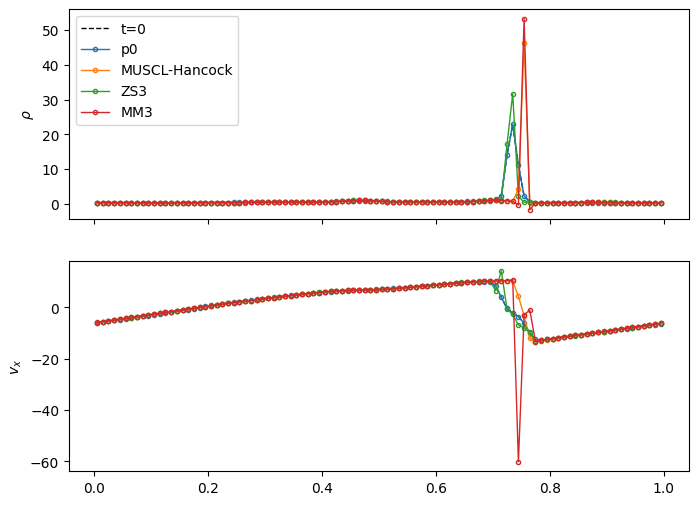

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")

style0 = dict(color="k", linestyle="--", linewidth=1)
style1 = dict(linewidth=1, markersize=3, marker="o", mfc="none")

plot_1d_slice(sims["p0"], axs[0], "rho", label="t=0", **style0)
plot_1d_slice(sims["p0"], axs[1], "vx", label="t=0", **style0)

for name, sim in sims.items():
    plot_1d_slice(sim, axs[0], "rho", label=name, **style1)
    plot_1d_slice(sim, axs[1], "vx", label=name, **style1)
axs[0].legend()